In [48]:
#Versioning
#Version 3: Removed elements for which province/country were NaN
#Version 2: Removed duplicates based on description and quality (to avoid giving frequent reviews more weight in the training)

#Note to reader: the code was run on Colab

In [49]:
#Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn import datasets, metrics
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import csv

In [50]:
#Get data from repository
!git clone https://github.com/shanmcm/Assignment

fatal: destination path 'Assignment' already exists and is not an empty directory.


In [51]:
#Path
path = 'Assignment/'
#Train
data = pd.read_csv(path+'dev.tsv', sep='\t')
#Eval
eval_data = pd.read_csv(path+'eval.tsv', sep='\t')

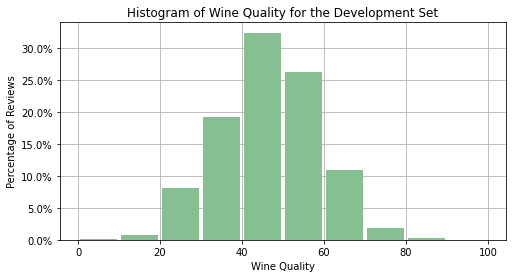

In [52]:
#Analise the distribution of the quality of wine (gaussian trend)
plt.figure(figsize=(8,4))
h = plt.hist(data['quality'], 10, weights=(np.ones(len(data['quality'])) / len(data['quality'])),facecolor='#86bf91', zorder=2, rwidth=0.9)
plt.xlabel('Wine Quality')
plt.ylabel('Percentage of Reviews')
plt.title('Histogram of Wine Quality for the Development Set')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig(path+'wine_dev.png')
plt.show()

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


In [54]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30186 entries, 0 to 30185
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      30186 non-null  object
 1   description  30186 non-null  object
 2   designation  20969 non-null  object
 3   province     30186 non-null  object
 4   region_1     25134 non-null  object
 5   region_2     12217 non-null  object
 6   variety      30186 non-null  object
 7   winery       30186 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB


In [55]:
data[~data.isna().any(axis=1)].head()

,country,description,designation,province,region_1,region_2,variety,winery,quality
7,US,One of the more successful blush wines out the...,Estate Grown,California,Dry Creek Valley,Sonoma,Rosé,Fritz,37.0
8,US,Although new oak accounts for only 10% of the ...,Vineyard Montage,California,Monterey County,Central Coast,Chardonnay,Cru,45.0
10,US,"Soft, fruity and simple, with upfront flavors ...",Coastal - Private Selection,California,Central Coast,Central Coast,Johannisberg Riesling,Robert Mondavi,24.0
14,US,Pure Syrah from the best blocks of the estate ...,Seven Hills Vineyard Estate,Washington,Walla Walla Valley (WA),Columbia Valley,Syrah,L'Ecole No. 41,53.0
17,US,Give this young Bordeaux blend a good decantin...,Red Rhythm,California,Paso Robles,Central Coast,Bordeaux-style Red Blend,B&E;,46.0


In [56]:
data[~data.isna().any(axis=1)].shape[0]

31553

In [57]:
data.iloc[7][1]

"One of the more successful blush wines out there, this one's crisp and elegant. It has polished flavors of raspberries, rose petals, gingersnap cookie and peppery spices, and the finish is super-dry. Nice with bouillibaisse, or try with cured meat appetizers."

In [58]:
data['quality'].describe()

count    120744.000000
mean         46.277852
std          11.924781
min           0.000000
25%          38.000000
50%          46.000000
75%          55.000000
max         100.000000
Name: quality, dtype: float64

In [59]:
print(f"Data has {data.shape[0]} entries")

Data has 120744 entries


In [60]:
print("(Column Name, # NaN values)")
print("---------------------------")
data.isna().sum()

(Column Name, # NaN values)
---------------------------


country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72008
variety            0
winery             0
quality            0
dtype: int64

In [61]:
print("(Column Name, # Distinct values)")
print("--------------------------------")
data.nunique()

(Column Name, # Distinct values)
--------------------------------


country           48
description    85005
designation    27800
province         444
region_1        1206
region_2          18
variety          603
winery         14105
quality           86
dtype: int64

In [62]:
(data[(data['region_1'].isna()) & (data['region_2'].isna())].index==data[data['region_1'].isna()].index).all()

True

In [63]:
(data[data['province'].isna()].index==data[data['country'].isna()].index).all()

True

This inspection suggests we discard region_2 (which has many missing values and is in relation to region_1) and country, since province is more detailes and has the same number of missing values

In [64]:
#Eliminate 5 NaN values of country (or equivalently province)
data=data[data['country'].notna()]
data.isna().sum()

country            0
description        0
designation    36518
province           0
region_1       20003
region_2       72003
variety            0
winery             0
quality            0
dtype: int64

In [65]:
#There are duplicates of reviews
d='A little bit funky and unsettled when you pop the screwcap, but soon it finds its floral, blueberry base. Remains superficial and sweet in the mouth, with candied flavors, vanilla and mild oak. Highly regular; could use more concentration and density.'
data[data['description']==d].head() 

,country,description,designation,province,region_1,region_2,variety,winery,quality
11236,France,A little bit funky and unsettled when you pop ...,Domaine Vincent Sauvestre Clos de la Platière,Burgundy,Pommard,NaN,Pinot Noir,Maison Jean-Baptiste Béjot,42.0
15395,France,A little bit funky and unsettled when you pop ...,Domaine Vincent Sauvestre Clos de la Platière,Burgundy,Pommard,NaN,Pinot Noir,Maison Jean-Baptiste Béjot,42.0
26883,Argentina,A little bit funky and unsettled when you pop ...,NaN,Mendoza Province,Mendoza,NaN,Malbec,Mariana,27.0
30457,Argentina,A little bit funky and unsettled when you pop ...,NaN,Mendoza Province,Mendoza,NaN,Malbec,Mariana,27.0
57271,Argentina,A little bit funky and unsettled when you pop ...,NaN,Mendoza Province,Mendoza,NaN,Malbec,Mariana,27.0


According to the text of the assignment each entry is supposed to refer to a single review. For this reason reviews for which the description and quality values are equal will be eliminated.

In [66]:
#Eliminate duplicates
print(f"Initial size of dev: {data.shape[0]}")
data.drop_duplicates(subset=['description','quality'], keep='first', inplace=True)
print(f"Final size of dev: {data.shape[0]}")

Initial size of dev: 120739
Final size of dev: 85012


In [67]:
#Double check
data[data['description']==d].head() 

,country,description,designation,province,region_1,region_2,variety,winery,quality
11236,France,A little bit funky and unsettled when you pop ...,Domaine Vincent Sauvestre Clos de la Platière,Burgundy,Pommard,NaN,Pinot Noir,Maison Jean-Baptiste Béjot,42.0
26883,Argentina,A little bit funky and unsettled when you pop ...,NaN,Mendoza Province,Mendoza,NaN,Malbec,Mariana,27.0


In [68]:
#Process Data
y = data['quality']
data = data.fillna('null')
eval_data = eval_data.fillna('null')

train_description = data['description']
eval_description = eval_data['description']
train_designation = data['designation']
eval_designation = eval_data['designation']

In [69]:
#Tfidf on description and designation
vectorizer = TfidfVectorizer(strip_accents='unicode',min_df=2,max_df=0.9,ngram_range=(1,3),stop_words='english',max_features=None)
train_tfidf = vectorizer.fit_transform(train_description)
eval_tfidf = vectorizer.transform(eval_description)

vectorizer2 = TfidfVectorizer(strip_accents='unicode',min_df=2,max_df=0.9,ngram_range=(1,3),stop_words='english',max_features=None)
train_tfidf_2 = vectorizer2.fit_transform(train_designation)
eval_tfidf_2 = vectorizer2.transform(eval_designation)

In [70]:
#Define columns to keep
columns = ['winery', 'variety', 'province', 'region_1']
data = data[columns]
eval_data = eval_data[columns]

#Set eval values to 'remove_me' if value is not present in data (to avoid extra encoding further on)
for column in columns:
  item_set = set(data[column])
  for index, value in enumerate(eval_data[column]):
    if value not in item_set:
      eval_data[column][index] = 'remove_me'

training = len(data)
concatenation = pd.concat([data,eval_data])
del data, eval_data

#Dummy-encoding (column names that end with 'remove_me' are ignored)
dummies = pd.get_dummies(concatenation,columns)
columns = [ column for column in dummies.columns if column[-9:] != 'remove_me']
x = dummies[:training][columns]
x_test = dummies[training:][columns]

#Free memory
del dummies, columns, concatenation

In [71]:
#Many categorical values => sparse matrices
#Compress using csr_matrix from scipy.sparse
x = csr_matrix(x)
x_test = csr_matrix(x_test)

#Define final data to be used to obtain model
x = hstack([x,train_tfidf,train_tfidf_2])
x_test = hstack([x_test,eval_tfidf,eval_tfidf_2])

In [72]:
#Train Test Split
x_train, x_val, y_train, y_val = train_test_split(x,y,train_size=0.8, random_state=0)

In [73]:
#Define score to use
score='r2'

In [74]:
#Define function for GridSearch
def best_regressor(x_train, y_train, x_val, y_val, regressor, score, grid, njobs ):
  gs = GridSearchCV(regressor, grid, cv=3, scoring=score, n_jobs=njobs, verbose=1)
  gs.fit(x_train, y_train)
  print("Best parameters set:")
  print(gs.best_params_)
  y_pred = gs.predict(x_val)
  print(f"r2 score: {r2_score(y_val,y_pred)}") 
  return gs

In [75]:
#Baseline LR
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_val)
r2_score(y_val,y_pred) 

0.7326975313569026

In [76]:
#Hyperparameter tuning for LR
fit_intercept=[True,False]
normalize=[True,False]
n_jobs=[-1]
grid = {'fit_intercept':fit_intercept,
        'normalize':normalize,
        'n_jobs':n_jobs}
regressor = LinearRegression()
njobs=-1
best_lr = best_regressor(x_train, y_train, x_val, y_val, regressor, score, grid, njobs)
lr = LinearRegression(**best_lr.best_params_) #0.732

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.1min finished


Best parameters set:
{'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
r2 score: 0.7326975313569026


In [77]:
#Baseline SVR
svr = LinearSVR()
svr.fit(x_train,y_train)
y_pred = svr.predict(x_val)
r2_score(y_val,y_pred) 

0.7233363996063572

In [78]:
#Hyperparameter tuning for SVR
C=[1, 10, 100, 1000]
loss=['epsilon_insensitive','squared_epsilon_insensitive']
fit_intercept=[True,False]
dual=[True,False]
grid = {'C':C,
        'loss':loss,
        'fit_intercept':fit_intercept,
        'dual':dual}
regressor = LinearSVR()
njobs=-1
best_svr = best_regressor(x_train, y_train, x_val, y_val, regressor, score, grid, njobs)
svr = LinearSVR(**best_svr.best_params_) #0.764

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  7.9min finished


Best parameters set:
{'C': 1, 'dual': False, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive'}
r2 score: 0.7643078699945546


In [79]:
#Baseline KN
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)
y_pred = knn.predict(x_val)
r2_score(y_val,y_pred)

0.6716161683040854

In [81]:
#Hyperparameter tuning for KN
n_neighbors=[3,4,5]
weights=['uniform','distance']
algorithm = ['brute'] #cannot use BallTree or KDTree with sparse input 
#leaf_size=[20,30,40]
grid = {'n_neighbors': n_neighbors,
        'weights': weights,
        'algorithm': algorithm}
        #'leaf_size':leaf_size}
regressor = KNeighborsRegressor()
njobs=1 #to avoid memory leak
best_knn = best_regressor(x_train, y_train, x_val, y_val, regressor, score, grid, njobs)
knn=KNeighborsRegressor(**best_knn.best_params_) #0.685

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 13.2min finished


Best parameters set:
{'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
r2 score: 0.6858547897574844


In [82]:
#Final model
model = VotingRegressor([('lr', lr),('svm', svr), ('knn', knn)])
model.fit(x_train,y_train)
y_pred = model.predict(x_val)
r2_score(y_val,y_pred) #0.773

0.7738460509600938

In [83]:
#Predict 
model.fit(x,y)
y_test = model.predict(x_test)

In [84]:
#Save results in CSV file
with open(path+'submission_final.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',',lineterminator='\r', quotechar='"', quoting=csv.QUOTE_NONE)
    writer.writerow(['Id', 'Predicted'])  
    for i in range(len(y_test)):
        writer.writerow([i, y_test[i]])

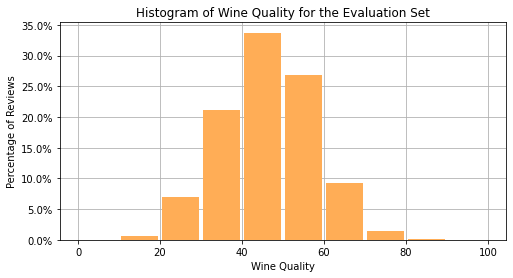

In [85]:
#Analise the distribution of the quality of wine for evaluation set
plt.figure(figsize=(8,4))
h = plt.hist(y_test, 10, weights=(np.ones(len(y_test)) / len(y_test)), range=(0,100), facecolor='#ffad56', zorder=2, rwidth=0.9)
plt.xlabel('Wine Quality')
plt.ylabel('Percentage of Reviews')
plt.title('Histogram of Wine Quality for the Evaluation Set')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig(path+'wine_ev.png')
plt.show()